In [126]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import playergamelog, leaguedashteamstats
from nba_api.stats.static import players, teams
from datetime import datetime, timedelta
import time
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning (we'll use these later)
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [127]:
# =============================================================================
# CREATE PROJECT FOLDERS
# =============================================================================

import os

folders = [
    "data/raw",
    "data/processed",
    "data/external",
    "notebooks",
    "src/data",
    "src/features",
    "src/models"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)
    print(f"Created: {folder}")

print("\nFolder structure ready ✓")

Created: data/raw
Created: data/processed
Created: data/external
Created: notebooks
Created: src/data
Created: src/features
Created: src/models

Folder structure ready ✓


In [128]:
# =============================================================================
# DATA COLLECTION FUNCTIONS
# =============================================================================

def get_player_id(player_name):
    """
    Convert player name to NBA.com player ID.
    """
    player_list = players.get_players()
    player = [p for p in player_list if p['full_name'].lower() == player_name.lower()]
    
    if not player:
        raise ValueError(f"Player '{player_name}' not found")
    
    return player[0]['id']


def get_player_game_log(player_name, season='2024-25'):
    """
    Pull all games for a player in a given season.
    """
    player_id = get_player_id(player_name)
    
    log = playergamelog.PlayerGameLog(
        player_id=player_id,
        season=season,
        season_type_all_star='Regular Season'
    )
    
    df = log.get_data_frames()[0]
    df['PLAYER_NAME'] = player_name
    
    return df


def get_player_multi_season(player_name, seasons=['2022-23', '2023-24', '2024-25']):
    """
    Pull game logs across multiple seasons.
    """
    all_games = []
    
    for season in seasons:
        try:
            df = get_player_game_log(player_name, season)
            df['SEASON'] = season
            all_games.append(df)
            print(f"  {player_name} | {season}: {len(df)} games")
            time.sleep(0.5)
            
        except Exception as e:
            print(f"  {player_name} | {season}: Failed - {e}")
    
    if not all_games:
        return pd.DataFrame()
    
    return pd.concat(all_games, ignore_index=True)


def build_dataset(player_names, seasons=['2022-23', '2023-24', '2024-25']):
    """
    Build full dataset across multiple players and seasons.
    """
    all_data = []
    
    for i, player in enumerate(player_names):
        print(f"[{i+1}/{len(player_names)}] Pulling {player}...")
        
        df = get_player_multi_season(player, seasons)
        
        if not df.empty:
            all_data.append(df)
        
        time.sleep(1)
    
    full_df = pd.concat(all_data, ignore_index=True)
    print(f"\n{'='*40}")
    print(f"Total games collected: {len(full_df)}")
    print(f"Total players: {full_df['PLAYER_NAME'].nunique()}")
    
    return full_df

print("Functions defined ✓")

Functions defined ✓


In [129]:
# =============================================================================
# BUILD DATASET
# =============================================================================

PLAYERS = [
    "Jayson Tatum",
    "Luka Dončić",              # Special character
    "Shai Gilgeous-Alexander",
    "Giannis Antetokounmpo",
    "Joel Embiid",
    "Nikola Jokić",             # Special character
    "Kevin Durant",
    "LeBron James",
    "Stephen Curry",
    "Anthony Edwards"
]

dataset = build_dataset(PLAYERS)


# Save raw data
dataset.to_csv("data/raw/player_game_logs.csv", index=False)
print("\nSaved to data/raw/player_game_logs.csv")

[1/10] Pulling Jayson Tatum...
  Jayson Tatum | 2022-23: 74 games
  Jayson Tatum | 2023-24: 74 games
  Jayson Tatum | 2024-25: 72 games
[2/10] Pulling Luka Dončić...
  Luka Dončić | 2022-23: 66 games
  Luka Dončić | 2023-24: 70 games
  Luka Dončić | 2024-25: 50 games
[3/10] Pulling Shai Gilgeous-Alexander...
  Shai Gilgeous-Alexander | 2022-23: 68 games
  Shai Gilgeous-Alexander | 2023-24: 75 games
  Shai Gilgeous-Alexander | 2024-25: 76 games
[4/10] Pulling Giannis Antetokounmpo...
  Giannis Antetokounmpo | 2022-23: 63 games
  Giannis Antetokounmpo | 2023-24: 73 games
  Giannis Antetokounmpo | 2024-25: 67 games
[5/10] Pulling Joel Embiid...
  Joel Embiid | 2022-23: 66 games
  Joel Embiid | 2023-24: 39 games
  Joel Embiid | 2024-25: 19 games
[6/10] Pulling Nikola Jokić...
  Nikola Jokić | 2022-23: 69 games
  Nikola Jokić | 2023-24: 79 games
  Nikola Jokić | 2024-25: 70 games
[7/10] Pulling Kevin Durant...
  Kevin Durant | 2022-23: 47 games
  Kevin Durant | 2023-24: 75 games
  Kevin Dur

In [130]:
# Load and inspect
df = pd.read_csv("data/raw/player_game_logs.csv")

print(f"Shape: {df.shape}")
print(f"\nPlayers: {df['PLAYER_NAME'].unique()}")
print(f"\nSeasons: {df['SEASON'].unique()}")
print(f"\nColumns: {df.columns.tolist()}")


Shape: (1987, 29)

Players: <StringArray>
[           'Jayson Tatum',             'Luka Dončić',
 'Shai Gilgeous-Alexander',   'Giannis Antetokounmpo',
             'Joel Embiid',            'Nikola Jokić',
            'Kevin Durant',            'LeBron James',
           'Stephen Curry',         'Anthony Edwards']
Length: 10, dtype: str

Seasons: <StringArray>
['2022-23', '2023-24', '2024-25']
Length: 3, dtype: str

Columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'PLAYER_NAME', 'SEASON']


# EDA

In [131]:
# Target variable summary (Points)
print("=== POINTS DISTRIBUTION ===")
print(df['PTS'].describe())

print("\n=== BY PLAYER ===")
print(df.groupby('PLAYER_NAME')['PTS'].agg(['mean', 'std', 'min', 'max']).round(1))

=== POINTS DISTRIBUTION ===
count    1987.000000
mean       28.507801
std         8.823965
min         0.000000
25%        23.000000
50%        29.000000
75%        34.000000
max        73.000000
Name: PTS, dtype: float64

=== BY PLAYER ===
                         mean  std  min  max
PLAYER_NAME                                 
Anthony Edwards          26.0  9.0    0   53
Giannis Antetokounmpo    30.6  9.1    2   64
Jayson Tatum             27.9  7.9    7   51
Joel Embiid              32.2  9.7    9   70
Kevin Durant             27.4  7.2   11   45
LeBron James             26.1  7.6   10   48
Luka Dončić              31.8  9.3    0   73
Nikola Jokić             26.8  8.9    4   61
Shai Gilgeous-Alexander  31.4  7.2    7   54
Stephen Curry            26.6  9.6    2   60


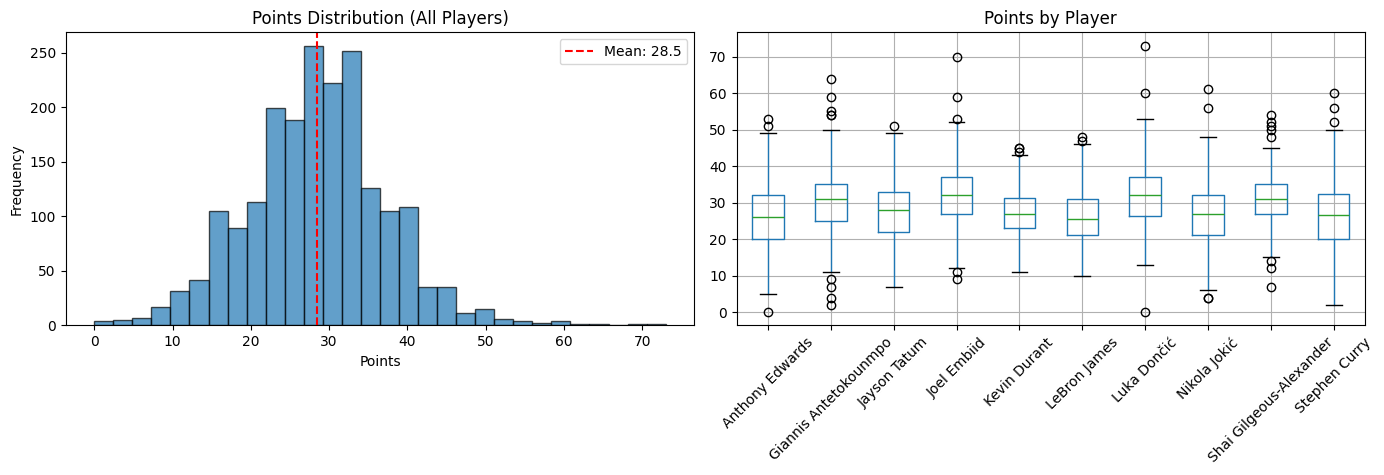

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(df['PTS'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Points Distribution (All Players)')
axes[0].axvline(df['PTS'].mean(), color='red', linestyle='--', label=f"Mean: {df['PTS'].mean():.1f}")
axes[0].legend()

# By player (box plot)
df.boxplot(column='PTS', by='PLAYER_NAME', ax=axes[1], rot=45)
axes[1].set_title('Points by Player')
axes[1].set_xlabel('')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [133]:
# See what MIN looks like
print("=== MIN COLUMN INFO ===")
print(f"Data type: {df['MIN'].dtype}")
print(f"\nSample values:")
print(df['MIN'].head(10))

=== MIN COLUMN INFO ===
Data type: int64

Sample values:
0    20
1    38
2    36
3    31
4    32
5    32
6    35
7    39
8    36
9    37
Name: MIN, dtype: int64


In [134]:
# =============================================================================
# CHECK ZERO/LOW MINUTE GAMES
# =============================================================================

print("=== ZERO/LOW MINUTE GAMES ===")
print(f"Games with 0 minutes: {len(df[df['MIN'] == 0])}")
print(f"Games under 10 minutes: {len(df[df['MIN'] < 10])}")
print(f"Games under 15 minutes: {len(df[df['MIN'] < 15])}")

print("\n=== MINUTES DISTRIBUTION ===")
print(df['MIN'].describe())

=== ZERO/LOW MINUTE GAMES ===
Games with 0 minutes: 0
Games under 10 minutes: 5
Games under 15 minutes: 7

=== MINUTES DISTRIBUTION ===
count    1987.000000
mean       35.121288
std         4.821370
min         3.000000
25%        33.000000
50%        36.000000
75%        38.000000
max        53.000000
Name: MIN, dtype: float64


In [135]:
# See which games have low minutes
low_min = df[df['MIN'] < 15][['PLAYER_NAME', 'GAME_DATE', 'MATCHUP', 'MIN', 'PTS']]
print(f"\nLow minute games ({len(low_min)} total):")
print(low_min.sort_values('MIN'))


Low minute games (7 total):
                PLAYER_NAME     GAME_DATE      MATCHUP  MIN  PTS
241             Luka Dončić  Jan 26, 2023    DAL @ PHX    3    0
1889        Anthony Edwards  Dec 08, 2023    MIN @ MEM    4    0
640   Giannis Antetokounmpo  Feb 24, 2023  MIL vs. MIA    6    4
1758        Anthony Edwards  Mar 17, 2023    MIN @ CHI    8    8
641   Giannis Antetokounmpo  Feb 16, 2023    MIL @ CHI    9    2
220             Luka Dončić  Apr 07, 2023  DAL vs. CHI   13   13
944             Joel Embiid  Dec 23, 2024  PHI vs. SAS   14    9


# Remove Outliers

In [136]:
# =============================================================================
# DATA CLEANING
# =============================================================================

print(f"Before cleaning: {len(df)} games")

# Remove games under 15 minutes
df_clean = df[df['MIN'] >= 15].copy()

print(f"After cleaning: {len(df_clean)} games")
print(f"Removed: {len(df) - len(df_clean)} games")

Before cleaning: 1987 games
After cleaning: 1980 games
Removed: 7 games


In [137]:
# Check minutes distribution after cleaning
print("\n=== MINUTES AFTER CLEANING ===")
print(df_clean['MIN'].describe())

# Check points after cleaning
print("\n=== POINTS AFTER CLEANING ===")
print(df_clean['PTS'].describe())

print("\n=== BY PLAYER (cleaned) ===")
print(df_clean.groupby('PLAYER_NAME')['PTS'].agg(['count', 'mean', 'std']).round(1))


=== MINUTES AFTER CLEANING ===
count    1980.000000
mean       35.216667
std         4.548656
min        15.000000
25%        33.000000
50%        36.000000
75%        38.000000
max        53.000000
Name: MIN, dtype: float64

=== POINTS AFTER CLEANING ===
count    1980.000000
mean       28.590404
std         8.724948
min         2.000000
25%        23.000000
50%        29.000000
75%        34.000000
max        73.000000
Name: PTS, dtype: float64

=== BY PLAYER (cleaned) ===
                         count  mean  std
PLAYER_NAME                              
Anthony Edwards            235  26.2  8.8
Giannis Antetokounmpo      201  30.9  8.7
Jayson Tatum               220  27.9  7.9
Joel Embiid                123  32.3  9.5
Kevin Durant               184  27.4  7.2
LeBron James               196  26.1  7.6
Luka Dončić                184  32.1  8.9
Nikola Jokić               218  26.8  8.9
Shai Gilgeous-Alexander    219  31.4  7.2
Stephen Curry              200  26.6  9.6


In [138]:
# Save to processed folder
df_clean.to_csv("data/processed/player_game_logs_clean.csv", index=False)
print("\nSaved to data/processed/player_game_logs_clean.csv ✓")


Saved to data/processed/player_game_logs_clean.csv ✓


# Feature Engineering

In [139]:
# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

# Load cleaned data
df = pd.read_csv("data/processed/player_game_logs_clean.csv")

print(f"Loaded {len(df)} games")
print(f"Columns: {df.columns.tolist()}")

Loaded 1980 games
Columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'PLAYER_NAME', 'SEASON']


In [140]:
# Convert GAME_DATE to datetime
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

# Sort by player and date (oldest first)
# WHY: Rolling averages need chronological order
df = df.sort_values(['PLAYER_NAME', 'GAME_DATE']).reset_index(drop=True)

print("Data sorted by player and date ✓")
print(df[['PLAYER_NAME', 'GAME_DATE', 'PTS']].head(10))

Data sorted by player and date ✓
       PLAYER_NAME  GAME_DATE  PTS
0  Anthony Edwards 2022-10-19   11
1  Anthony Edwards 2022-10-21   30
2  Anthony Edwards 2022-10-23   30
3  Anthony Edwards 2022-10-24    9
4  Anthony Edwards 2022-10-26   34
5  Anthony Edwards 2022-10-28   29
6  Anthony Edwards 2022-10-30   18
7  Anthony Edwards 2022-11-01   24
8  Anthony Edwards 2022-11-04   24
9  Anthony Edwards 2022-11-05   19


In [141]:
# =============================================================================
# FEATURE: HOME/AWAY
# =============================================================================

# MATCHUP column shows "BOS vs. MIA" (home) or "BOS @ MIA" (away)
df['HOME'] = df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# Verify
print("=== HOME/AWAY ===")
print(df['HOME'].value_counts())
print(f"\nHome game points avg: {df[df['HOME'] == 1]['PTS'].mean():.1f}")
print(f"Away game points avg: {df[df['HOME'] == 0]['PTS'].mean():.1f}")

=== HOME/AWAY ===
HOME
1    1003
0     977
Name: count, dtype: int64

Home game points avg: 28.8
Away game points avg: 28.4


In [142]:
# =============================================================================
# FEATURE: REST DAYS
# =============================================================================

def calculate_rest_days(group):
    """
    Calculate days since last game for each player.
    
    WHY: Fatigue affects performance. Back-to-backs = fewer points typically.
    """
    group = group.sort_values('GAME_DATE')
    group['REST_DAYS'] = group['GAME_DATE'].diff().dt.days
    return group

df = df.groupby('PLAYER_NAME', group_keys=False).apply(calculate_rest_days)

# First game of season has NaN rest days — fill with 7 (assumed fresh)
df['REST_DAYS'] = df['REST_DAYS'].fillna(7)

# Cap at 7 (more than a week doesn't add benefit)
df['REST_DAYS'] = df['REST_DAYS'].clip(upper=7)

# Back-to-back flag (1 rest day = played yesterday)
df['B2B'] = (df['REST_DAYS'] == 1).astype(int)

# Verify
print("=== REST DAYS ===")
print(df['REST_DAYS'].value_counts().sort_index())
print(f"\nBack-to-back games: {df['B2B'].sum()}")
print(f"B2B points avg: {df[df['B2B'] == 1]['PTS'].mean():.1f}")
print(f"Non-B2B points avg: {df[df['B2B'] == 0]['PTS'].mean():.1f}")

=== REST DAYS ===
REST_DAYS
1.0     284
2.0    1137
3.0     326
4.0      91
5.0      24
6.0      10
7.0     108
Name: count, dtype: int64

Back-to-back games: 284
B2B points avg: 28.9
Non-B2B points avg: 28.5


In [143]:
# =============================================================================
# ADD PLAYER NAMES BACK
# =============================================================================

def get_player_name_from_id(player_id):
    """Convert Player_ID back to name."""
    player_list = players.get_players()
    player = [p for p in player_list if p['id'] == player_id]
    
    if player:
        return player[0]['full_name']
    return f"Unknown_{player_id}"

# Get unique player IDs
unique_ids = df['Player_ID'].unique()

# Create mapping
id_to_name = {pid: get_player_name_from_id(pid) for pid in unique_ids}

# Add column
df['PLAYER_NAME'] = df['Player_ID'].map(id_to_name)

# Verify
print("=== PLAYERS ===")
print(df['PLAYER_NAME'].unique())

=== PLAYERS ===
<StringArray>
[        'Anthony Edwards',   'Giannis Antetokounmpo',
            'Jayson Tatum',             'Joel Embiid',
            'Kevin Durant',            'LeBron James',
             'Luka Dončić',            'Nikola Jokić',
 'Shai Gilgeous-Alexander',           'Stephen Curry']
Length: 10, dtype: str


In [144]:
# Calculate rolling averages per player
for pid in df['Player_ID'].unique():
    mask = df['Player_ID'] == pid
    pts_shifted = df.loc[mask, 'PTS'].shift(1)
    
    df.loc[mask, 'ROLL_PTS_3'] = pts_shifted.rolling(window=3, min_periods=1).mean()
    df.loc[mask, 'ROLL_PTS_5'] = pts_shifted.rolling(window=5, min_periods=1).mean()
    df.loc[mask, 'ROLL_PTS_10'] = pts_shifted.rolling(window=10, min_periods=1).mean()

print("=== ROLLING AVERAGES (sample) ===")
sample_pid = df['Player_ID'].iloc[0]
sample = df[df['Player_ID'] == sample_pid][['GAME_DATE', 'PTS', 'ROLL_PTS_3', 'ROLL_PTS_5']].head(10)
print(sample)

=== ROLLING AVERAGES (sample) ===
   GAME_DATE  PTS  ROLL_PTS_3  ROLL_PTS_5
0 2022-10-19   11         NaN         NaN
1 2022-10-21   30   11.000000   11.000000
2 2022-10-23   30   20.500000   20.500000
3 2022-10-24    9   23.666667   23.666667
4 2022-10-26   34   23.000000   20.000000
5 2022-10-28   29   24.333333   22.800000
6 2022-10-30   18   24.000000   26.400000
7 2022-11-01   24   27.000000   24.000000
8 2022-11-04   24   23.666667   22.800000
9 2022-11-05   19   22.000000   25.800000


In [145]:
# Calculate expanding season average per player per season
# shift(1) ensures we only use PAST games

for pid in df['Player_ID'].unique():
    for season in df['SEASON'].unique():
        mask = (df['Player_ID'] == pid) & (df['SEASON'] == season)
        if mask.sum() > 0:
            pts_shifted = df.loc[mask, 'PTS'].shift(1)
            df.loc[mask, 'SEASON_AVG_PTS'] = pts_shifted.expanding(min_periods=1).mean()

# Fill NaN (first game of season) with player overall average
player_avgs = df.groupby('Player_ID')['PTS'].mean()

for pid in df['Player_ID'].unique():
    mask = (df['Player_ID'] == pid) & (df['SEASON_AVG_PTS'].isna())
    df.loc[mask, 'SEASON_AVG_PTS'] = player_avgs[pid]

print("=== SEASON AVERAGES ===")
print(df.groupby('Player_ID')['SEASON_AVG_PTS'].mean().round(1))

=== SEASON AVERAGES ===
Player_ID
2544       25.3
201142     28.5
201939     26.9
203507     31.0
203954     31.2
203999     26.9
1628369    28.9
1628983    30.8
1629029    32.1
1630162    25.7
Name: SEASON_AVG_PTS, dtype: float64


In [ ]:
# Verify All Features
feature_cols = ['HOME', 'REST_DAYS', 'B2B', 'ROLL_PTS_3', 'ROLL_PTS_5', 'ROLL_PTS_10', 'SEASON_AVG_PTS']

print("=== FEATURE SUMMARY ===")
print(df[feature_cols].describe().round(2))

print("\n=== MISSING VALUES ===")
print(df[feature_cols].isnull().sum())

print("\n=== SAMPLE ROW ===")
print(df[['Player_ID', 'GAME_DATE', 'PTS'] + feature_cols].iloc[50])

=== FEATURE SUMMARY ===
          HOME  REST_DAYS      B2B  ROLL_PTS_3  ROLL_PTS_5  ROLL_PTS_10  \
count  1980.00    1980.00  1980.00     1970.00     1970.00      1970.00   
mean      0.51       2.44     0.14       28.62       28.62        28.63   
std       0.50       1.36     0.35        5.52        4.64         3.89   
min       0.00       1.00     0.00       11.00       11.00        11.00   
25%       0.00       2.00     0.00       25.00       25.40        25.70   
50%       1.00       2.00     0.00       28.67       28.60        28.60   
75%       1.00       3.00     0.00       32.33       31.80        31.40   
max       1.00       7.00     1.00       48.67       45.60        40.40   

       SEASON_AVG_PTS  
count         1980.00  
mean            28.56  
std              3.42  
min             11.00  
25%             26.26  
50%             28.68  
75%             31.06  
max             41.00  

=== MISSING VALUES ===
HOME               0
REST_DAYS          0
B2B               

In [147]:
# Save featured data
df.to_csv("data/processed/player_game_logs_featured.csv", index=False)
print("Saved to data/processed/player_game_logs_featured.csv ✓")

Saved to data/processed/player_game_logs_featured.csv ✓
